In [2]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Data

In [5]:
df = pd.read_csv('/kaggle/input/next-word-prediciton/twitter_training.csv', header = None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df[2].value_counts()

2
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

## Task: Given Various tweets, Build a LSTM model to predict a Next ord of a sentence

In [10]:
tweets = df.iloc[:,3:4]
tweets

,3
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...
...,...
74677,Just realized that the Windows partition of my...
74678,Just realized that my Mac window partition is ...
74679,Just realized the windows partition of my Mac ...
74680,Just realized between the windows partition of...


In [11]:
# Changing Column names
tweets.columns = ['Tweets']
tweets.head()

,Tweets
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...


In [12]:
re_special_char = "[^a-z\s]"
def text_preprocessing(review):
  review = str(review)
  #Normalizing the case
  review = review.lower()
  # Removal of special characters
  review = re.sub(re_special_char, "",review)
  return review

In [13]:
tweets['Tweets'] = tweets['Tweets'].apply(text_preprocessing)

## Tokenization : Every word will be given unique position in vocabulary

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

2024-02-23 06:30:09.348706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 06:30:09.348832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 06:30:09.672369: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
tk = Tokenizer()
tweets['Tweets'] = tweets['Tweets'].astype(str)
tk.fit_on_texts(tweets['Tweets'])
tk.word_index

{'the': 1,
 'i': 2,
 'to': 3,
 'and': 4,
 'a': 5,
 'of': 6,
 'is': 7,
 'for': 8,
 'in': 9,
 'this': 10,
 'it': 11,
 'you': 12,
 'on': 13,
 'my': 14,
 'that': 15,
 'with': 16,
 'game': 17,
 'so': 18,
 'me': 19,
 'have': 20,
 'just': 21,
 'but': 22,
 'not': 23,
 'are': 24,
 'be': 25,
 'all': 26,
 'was': 27,
 'at': 28,
 'its': 29,
 'im': 30,
 'like': 31,
 'out': 32,
 'from': 33,
 'your': 34,
 'now': 35,
 'get': 36,
 'we': 37,
 'as': 38,
 'they': 39,
 'has': 40,
 'if': 41,
 'one': 42,
 'do': 43,
 'good': 44,
 'about': 45,
 'can': 46,
 'play': 47,
 'no': 48,
 'will': 49,
 'an': 50,
 'really': 51,
 'when': 52,
 'love': 53,
 'new': 54,
 'up': 55,
 'what': 56,
 'more': 57,
 'time': 58,
 'by': 59,
 'how': 60,
 'some': 61,
 'people': 62,
 'or': 63,
 'johnson': 64,
 'why': 65,
 'see': 66,
 'shit': 67,
 'cant': 68,
 'dont': 69,
 'been': 70,
 'best': 71,
 'still': 72,
 'got': 73,
 'games': 74,
 'great': 75,
 'even': 76,
 'playing': 77,
 'who': 78,
 'because': 79,
 'xbox': 80,
 'fucking': 81,
 'go':

In [17]:
len(tk.word_index)

38492

In [18]:
# To find specific word index
tk.word_index['fantastic']

682

In [19]:
tk.index_word[500]

'character'

## Should Fix no of I/P words to predict next word:
### As we already made each word as a token. We cannot give input as words. So we will give representation of tokens as I\P.

In [20]:
tweets['Tweets'][600]

'well this is certainly a development'

In [21]:
# Tokens are positions
token_list = tk.texts_to_sequences(["Well this is certainly a development"])
token_list = token_list[0]

In [22]:
input_sequences = []
for i in range(1,len(token_list)):
  n_gram_seq = token_list[0:i+2]
  input_sequences.append(n_gram_seq)

In [23]:
token_list

[160, 10, 7, 1296, 5, 1960]

In [24]:
"Well this is certainly a development"

'Well this is certainly a development'

In [25]:
# For single sentence
input_sequences

[[160, 10, 7],
 [160, 10, 7, 1296],
 [160, 10, 7, 1296, 5],
 [160, 10, 7, 1296, 5, 1960],
 [160, 10, 7, 1296, 5, 1960]]

In [26]:
# For all the tweets in the data applying the sequences

def gen_sequences(data):
  input_seq = []
  for each_tweet in data:
    token_list = tk.texts_to_sequences([each_tweet])
    token_list = token_list[0]
    for i in range(1,len(token_list)):
      n_gram_seq = token_list[0:i+2]
      input_seq.append(n_gram_seq)
  return input_seq

In [27]:
input_sequences = gen_sequences(tweets['Tweets'])

In [28]:
input_sequences

[[30, 157, 13],
 [30, 157, 13, 123],
 [30, 157, 13, 123, 4],
 [30, 157, 13, 123, 4, 2],
 [30, 157, 13, 123, 4, 2, 49],
 [30, 157, 13, 123, 4, 2, 49, 1656],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12, 26],
 [30, 157, 13, 123, 4, 2, 49, 1656, 12, 26],
 [2, 100, 378],
 [2, 100, 378, 3],
 [2, 100, 378, 3, 1],
 [2, 100, 378, 3, 1, 6319],
 [2, 100, 378, 3, 1, 6319, 4],
 [2, 100, 378, 3, 1, 6319, 4, 2],
 [2, 100, 378, 3, 1, 6319, 4, 2, 49],
 [2, 100, 378, 3, 1, 6319, 4, 2, 49, 405],
 [2, 100, 378, 3, 1, 6319, 4, 2, 49, 405, 12],
 [2, 100, 378, 3, 1, 6319, 4, 2, 49, 405, 12, 26],
 [2, 100, 378, 3, 1, 6319, 4, 2, 49, 405, 12, 26],
 [30, 157, 13],
 [30, 157, 13, 123],
 [30, 157, 13, 123, 4],
 [30, 157, 13, 123, 4, 2],
 [30, 157, 13, 123, 4, 2, 49],
 [30, 157, 13, 123, 4, 2, 49, 405],
 [30, 157, 13, 123, 4, 2, 49, 405, 12],
 [30, 157, 13, 123, 4, 2, 49, 405, 12, 26],
 [30, 157, 13, 123, 4, 2, 49, 405, 12, 26],
 [30, 378, 13],
 [30, 378, 13, 123],
 [30, 378, 13

## Converting X into X & y:
To convert into X and y the sequences should be of the same shape.        
But the data e have are not having same shape. So to make the sequences of same shape we use Pad Sequences.                
Pad sequences:         
(i) pre-padding        
(ii) Post padding

In [29]:
# Applying Pre-padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
# Finding max_length sequence from the input sequences
max_seq_length = max([len(seq)for seq in input_sequences])

In [31]:
input_sequences = pad_sequences(input_sequences, maxlen = max_seq_length, padding = 'pre')
input_sequences

array([[   0,    0,    0, ...,   30,  157,   13],
       [   0,    0,    0, ...,  157,   13,  123],
       [   0,    0,    0, ...,   13,  123,    4],
       ...,
       [   0,    0,    0, ...,   60,    2,  284],
       [   0,    0,    0, ...,    2,  284, 2008],
       [   0,    0,    0, ...,    2,  284, 2008]], dtype=int32)

In [32]:
input_sequences.shape

(1256718, 166)

In [33]:
sliced_seq = input_sequences[0:100000,:]
sliced_seq.shape

(100000, 166)

## Converting the sequences into X and y

In [34]:
X = sliced_seq[:,:-1]
X.shape

(100000, 165)

In [35]:
y = sliced_seq[:,-1]
y.shape

(100000,)

In [36]:
# the label is classification but we have numbers. So, we want to convert to categorical
from tensorflow.keras.utils import to_categorical

In [37]:
y = to_categorical(y)
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
y.shape # 28224 chances to predict i.e, neurons

(100000, 28224)

In [39]:
# Total no of unique words in data
total_words = y.shape[1]
total_words

28224

In [40]:
# To avoid the unkown word (oov word)
total_words = total_words
total_words

28224

## Building the architecture

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Dense

### Initializing the Model

In [43]:
model = Sequential()

### Adding the Embedding layer

In [44]:
inp_seq_len = X.shape[1]

In [45]:
emb_layer = Embedding(total_words+1, 100, input_length = inp_seq_len)   # unique ords, dimensions, input_len_seq

In [46]:
model.add(emb_layer)

### Add the LSTM-1 Layer

In [47]:
# Return_sequences == True == when we want to add another LSTM layer after this
# Return_sequences == False == When we are adding a Dense layer after LSTM
lstm_layer_1 = LSTM(kernel_initializer = 'random_uniform',
                    return_sequences = True, units = 50)

In [48]:
model.add(lstm_layer_1)

### Add the LSTM-2 Layer

In [49]:
lstm_layer_2 = LSTM(kernel_initializer = 'random_uniform',
                    return_sequences = False, units = 80)

In [50]:
model.add(lstm_layer_2)

### Adding the output layer

In [51]:
output_layer = Dense(kernel_initializer = 'random_uniform', activation = 'softmax', units = total_words)

In [52]:
model.add(output_layer)

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 165, 100)          2822500   
                                                                 
 lstm (LSTM)                 (None, 165, 50)           30200     
                                                                 
 lstm_1 (LSTM)               (None, 80)                41920     
                                                                 
 dense (Dense)               (None, 28224)             2286144   
                                                                 
Total params: 5180764 (19.76 MB)
Trainable params: 5180764 (19.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


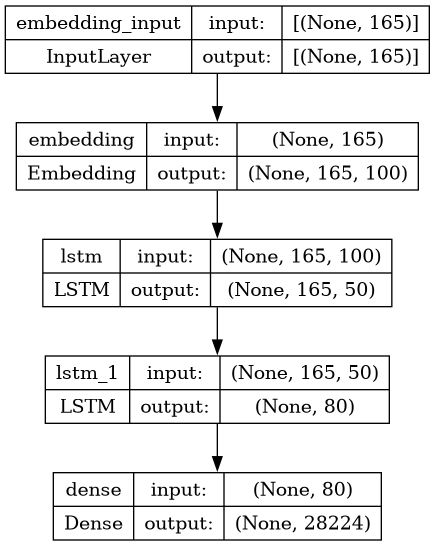

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

In [55]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [56]:
model.fit(X,y, epochs = 50, batch_size = 32)

Epoch 1/50


I0000 00:00:1708670044.643202     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 94s 29ms/step - loss: 7.0049 - accuracy: 0.0406
Epoch 2/50
3125/3125 [==============================] - 61s 19ms/step - loss: 6.1500 - accuracy: 0.0738
Epoch 3/50
3125/3125 [==============================] - 61s 19ms/step - loss: 5.5279 - accuracy: 0.1146
Epoch 4/50
3125/3125 [==============================] - 60s 19ms/step - loss: 4.9747 - accuracy: 0.1575
Epoch 5/50
3125/3125 [==============================] - 60s 19ms/step - loss: 4.4975 - accuracy: 0.2060
Epoch 6/50
3125/3125 [==============================] - 59s 19ms/step - loss: 4.0921 - accuracy: 0.2584
Epoch 7/50
3125/3125 [==============================] - 59s 19ms/step - loss: 3.7504 - accuracy: 0.3069
Epoch 8/50
3125/3125 [==============================] - 59s 19ms/step - loss: 3.4640 - accuracy: 0.3506
Epoch 9/50
3125/3125 [==============================] - 60s 19ms/step - loss: 3.2218 - accuracy: 0.3867
Epoch 10/50
3125/3125 [==============================] - 59s 19ms/step - lo

### Saving the model and Tokenizer : 
- In prediction time we can directly use these model and tokenizer we can predict.

In [67]:
# pickle
import pickle
from pickle import dump,load

model.save('Golve_trained_model.h5')
pickle.dump(tk, open('tokenizer.pkl', 'wb'))

### loading model and tokernizer

In [70]:
from keras.models import load_model
model = load_model("/kaggle/working/Glove_trained_model.h5")


In [71]:
tokenizer = pickle.load(open("/kaggle/working/tokenizer.pkl", 'rb'))

## Prediction  On User Input

In [78]:
input_text = ["this was the first Borderlands session in a long time where i actually had a really satisfying fighting experience. i got some really good kills"]
max_seq_len = 165

## Input preprocessing  step

In [79]:
re_special_char = "[^a-z\s]"
def text_preprocessing(review):
    # convert in to string to overcome from float values
    review = str(review)
    #Normalizing the case 
    review = review.lower()
    #Removal of special characters
    review = re.sub(re_special_char,"", review)
    return review

## Prediction step

In [80]:
def pred_next_word(text, max_seq_len, tokenizer):
    text = text_preprocessing(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen = max_seq_len, padding = "pre")
    y_pred = model.predict(text, verbose = 0)
    best_word_pred = np.argmax(y_pred)
    return tokenizer.index_word[best_word_pred]

## Result

In [81]:
print("original_text :", input_text)
print("######################")
word = "this was the first Borderlands session in a long"
for i in range(15):
    word = word + " " + pred_next_word(word,max_seq_len, tokenizer)
print(word)

original_text : ['this was the first Borderlands session in a long time where i actually had a really satisfying fighting experience. i got some really good kills']
######################
this was the first Borderlands session in a long time where i actually had a really satisfying combat experience i got some really good
